In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
words = open('names.txt','r').read().splitlines()

In [32]:
words[:10]

['gineez',
 'suhrita',
 'akhalesh',
 'miksen',
 'rashamkumar',
 'eak',
 'khushboo',
 'kukee',
 'punyadip',
 'kharel']

In [34]:
#removing . ( ) -
words = [w.replace('.', '').replace(',', '').replace('(', '').replace(')', '').replace('-', '') for w in words]


In [43]:
#creating lookup tables for characters\
chars = sorted(list(set(''.join(words))))

#words to encoding
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
# print(stoi)

#encoding to words
itos = {i:s for s,i in stoi.items()}
# print(itos)







In [174]:
#creating examples to train 

block_size = 3 #context length: how many input to take to predict next one
X,Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context),'-----',itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [342]:
#dataset but for splits

def build_dataset(words):
    block_size = 3 #context length: how many input to take to predict next one
    X,Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context),'-----',itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])
        







In [176]:
#creating embeddings - mapping to 2 dimensions the characters
C = torch.randn((27,2))


In [178]:
C[X].shape

torch.Size([59706, 3, 2])

In [180]:
emb = C[X]
emb.shape

torch.Size([59706, 3, 2])

In [182]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)


In [184]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [186]:
h.shape

torch.Size([59706, 100])

In [188]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [190]:
logits = h @ W2 + b2

In [192]:
logits.shape

torch.Size([59706, 27])

In [194]:
counts = logits.exp()
probs = counts/counts.sum(1,keepdims=True)

In [196]:
probs.shape

torch.Size([59706, 27])

In [200]:
loss

tensor(0.1925, grad_fn=<NllLossBackward0>)

In [202]:
##### Putting it all together

In [593]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,15),generator=g)
W1 = torch.randn((45,200),generator=g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [595]:
sum(p.nelement() for p in parameters)

15032

In [597]:
for p in parameters:
    p.requires_grad = True

In [599]:
lri = []
lossi = []
stepi = []

In [601]:

for i in range(50000):

    #constructing minibatch
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,45) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Ytr[ix])
    # print(loss.item())
    #backpass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    #tracking best lr's - we got around -0.1
    # lr = lrs[i]
    lr = 0.1 if i < 28000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())



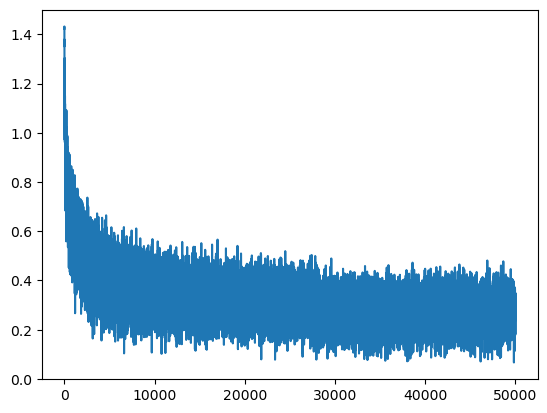

In [603]:
plt.plot(stepi,lossi)

In [605]:
torch.randint(0,X.shape[0],(32,))

tensor([47845,  4202, 35207,  7177, 31721, 13811, 55608, 59205, 42748,  4590,
        27049, 14931,  4163, 29050, 27537, 40262, 56747, 47497,  6009, 20271,
         6299, 22561, 30918, 41371, 42919, 29426,   452, 28605, 19516, 33157,
        52585, 23129])

In [607]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,45) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.1332, grad_fn=<NllLossBackward0>)

In [609]:
#training, validation and test validation split

In [611]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,45) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,Ytr)
loss

tensor(1.8795, grad_fn=<NllLossBackward0>)

In [615]:
#generating names !!!!!

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print (''.join(itos[i] for i in out))

mritam.
yaj.
sheswap.
rika.
remhas.
badrboj.
sheekant.
ing.
mippen.
akesh.
supalrajayanthokesh.
jshreer.
shivansh.
jair.
jen.
punter.
rous.
pradeepyinun.
mho.
ram.
